# Detect ARs from individual time steps


This notebook detects ARs at instantaneous time steps.

The detection is performed mainly on the anomalous IVT computed in the previous step (in notebook `2 compute_THR`), using these steps:

1. At any time point, find all contiguous regions from the `ivt_ano` field where `ivt_ano` $> 0\, kg/(m \cdot s)$.
2. Compute the centroid of all such regions, using the underlying IVT values as weights.
3. Discard all regions whose area is $\le 50 \times 10^4\, km^2$, or $\ge 1800 \times 10^4\,km^2$.
4. Discard all regions whose centroid lies north of $80^{\circ}\, N$, or south of $20^{\circ} N$.
6. Compute the AR axis.
7. Discard all regions whose AR axis is $\le 1500\, km$.
8. Compute the effective width as area/length, and the length/width ratio.
9. Discard all regions whose length/width ratio is $\le 2$, if length $< 2000\, km$.

All passing systems after the above steps are regarded as ARs.

There are some more details given in the parameter selection section down below.

In production, you can use the `scripts/detect_ARs.py` or `scripts/detect_ARs_generator_version.py` for this step.


## Input data

* `uflux_s_6_1984_Jan.nc`: u-component of vertically integrated vapor fluxes (`standard_name`: `eastward_atmosphere_water_transport_across_unit_distance`), in $kg/(m \cdot s)$.
* `vflux_s_6_1984_Jan.nc`: v-component of vertically integrated vapor fluxes (`standard_name`: `northward_atmosphere_water_transport_across_unit_distance`, in $kg/(m \cdot s)$.
* `ivt_s_6_1984_Jan-THR-kernel-t16-s6.nc`: decomposition of IVT using the THR algorithm, into a reconstruction component (`ivt_rec`) and the anomaly component (`ivt_ano`), in $kg/(m \cdot s)$.


## Steps

1. Make sure you have successfully run the previous notebook.
2. Execute the following code blocks in sequence.


## Results


* `ar_records.csv`: a csv table listing various attributes for each detected AR appearance.
* `ar_s_6_1984_labels.nc`: a netCDF data file saving these 3 variables:
    * `label`: integer labels distinguishing all ARs detected at individual time steps.
    * `angles`: the angle between horizontal vapor flux and the local AR axis, in degrees.
    * `ivt_cross`: cross-sectional IVT flux, computed as the product of IVT vector and cosine of `angles`.
* `plots/ar_YYYY-MM-DD HH:00.png` (optional): plots of IVT and detected ARs at individual time steps.

All results will be saved to the same folder as this notebook file.


## Plotting package

Note that to create plots, you will need to install the `cartopy` plotting package. Installation using `conda`:

```
conda install cartopy
```

## Set some global parameters

`YEAR`, `TIME_START`, and `TIME_END` are used to specify the time domain to process.

In this notebook only a small time subset is specified. In production you would want to set the time points to suit your needs.

In [1]:
#--------------------Time range--------------------
YEAR=2022
TIME_START='%d-06-01 18:00:00' %YEAR
TIME_END='%d-06-30 18:00:00' %YEAR  # NOTE: end point not included

Specify the input and output locations. A subfolder is created using the `YEAR` defined above.

In [2]:
%matplotlib inline
import os, sys

#-----------u-qflux----------------------
UQ_FILE_NAME=os.path.join('.', 'e-IVT-2022-06.nc')
UQ_VAR='p71.162'

#-----------v-qflux----------------------
VQ_FILE_NAME=os.path.join('.', 'n-IVT-2022-06.nc')
VQ_VAR='p72.162'

#-----------------ivt reconstruction and anomalies-----------------
IVT_FILE_NAME=os.path.join('.', 'IVT-2022-06-THR-kernel-t25-s18.nc')

#------------------Output folder------------------
OUTPUTDIR=os.path.join('.', str(YEAR))

* `PLOT` controls whether to plot figures of IVT with detected ARs.
* `SHIFT_LON` shifts the data along the x-dimension by 80 degrees so the Pacific and Atlantic oceans are centered.


In [3]:
PLOT=True          # create maps of found ARs or not
SHIFT_LON=0          # degree, shift left bound to longitude. Should match
                      # that used in compute_thr_singlefile.py

The `PARAM_DICT` dictionary contains important parameters used in the detection process:

* `thres_low`: float, a minimum IVT value in $kg/(m \cdot s)$. This tells the script to look for AR candidates as regions where the anomaly IVT (`ivt_ano`) >= this value. This is the same idea as the IVT250 thresholding method. In production one should give it a small nominal value like `1`, `10` etc., or just `0`.
* `min_area`: float, minimum area in $km^2$. Drop AR candidates smaller than this area. Region of area is defined as the summation of grid cell areas, computed using the latitude/longitude meta data of input data. This is used to filter out some miniature features.
* `max_area`: float, maximum area in $km^2$. Filter out regions too large in size. This might happen when 2 AR-like features get merged together. You can prevent this from happening by raising the `thres_low` value, or setting `SINGLE_DOME` to true.
* `min_LW`: float, minimal length/width ratio.
* `min_lat`: float, degree North, exclude systems whose centroids are lower than this latitude.
* `max_lat`: float, degree North, exclude systems whose centroids are higher than this latitude.
* `min_length`: float, km, AR candidates shorter than this length are flagged as `relaxed`.
* `min_length_hard`: float, km, AR candidates shorter than this length are discarded.
* `rdp_thres`: float, degree latitude/longitude, the user given error when simplifying axis using [rdp algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm).
* `fill_radius`: this is to fill up some holes found in the AR candidate regions. This can happen when your input data have pretty high resolution and tend to have more small scale features in the IVT field. Sometimes this will leave some small holes in the found AR region. Set to `None` will compute a default value based on data resolution.
* `single_dome`: `True` or `False` values control whether to separate local IVT maxima that are merged into one contour.
* `max_ph_ratio`: float in (0,1). Maximum prominence/height ratio of a local peak. Only used when SINGLE_DOME=True.
* `edge_eps`: float in (0,1). Minimal proportion of flux component in a direction to total flux to
    allow edge building in that direction. Setting this to a higher value will impose greater restriction upon the directions of the AR axis, requiring it to more strictly follow the vectors of IVT. Setting a lower value gives more maneuver space of the AR axis to pass through the AR region.

In [4]:
PARAM_DICT={
    # kg/m/s, define AR candidates as regions >= than this anomalous ivt.
    'thres_low' : 1,
    # km^2, drop AR candidates smaller than this area.
    'min_area': 50*1e4,
    # km^2, drop AR candidates larger than this area.
    'max_area': 1800*1e4,
    # float, minimal length/width ratio.
    'min_LW': 2,
    # degree, exclude systems whose centroids are lower than this latitude.
    'min_lat': 5,
    # degree, exclude systems whose centroids are higher than this latitude.
    'max_lat': 80,
    # km, ARs shorter than this length is treated as relaxed.
    'min_length': 2000,
    # km, ARs shorter than this length is discarded.
    'min_length_hard': 1500,
    # degree lat/lon, error when simplifying axis using rdp algorithm.
    'rdp_thres': 2,
    # grids. Remove small holes in AR contour.
    'fill_radius': None,
    # do peak partition or not, used to separate systems that are merged
    # together with an outer contour.
    'single_dome': False,
    # max prominence/height ratio of a local peak. Only used when single_dome=True
    'max_ph_ratio': 0.6,
    # minimal proportion of flux component in a direction to total flux to
    # allow edge building in that direction
    'edge_eps': 0.4
    }

Import the modules.

In [5]:
#--------Import modules-------------------------
import os, sys
import numpy as np
import pandas as pd
from ipart.utils import funcs
from ipart.AR_detector import findARs

c:\Users\User\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Then read in the input data, and do some slicing to select the part of data we want:

In [6]:
#-----------Read in flux data----------------------
qu=funcs.readNC(UQ_FILE_NAME, UQ_VAR)
qv=funcs.readNC(VQ_FILE_NAME, VQ_VAR)

#-------------------Read in ivt-------------------
print('\n# Read in file:\n',IVT_FILE_NAME)
ivt=funcs.readNC(IVT_FILE_NAME, 'ivt')
ivtrec=funcs.readNC(IVT_FILE_NAME, 'ivt_rec')
ivtano=funcs.readNC(IVT_FILE_NAME, 'ivt_ano')

#-----------------Shift longitude-----------------
qu=qu.shiftLon(SHIFT_LON)
qv=qv.shiftLon(SHIFT_LON)
ivt=ivt.shiftLon(SHIFT_LON)
ivtrec=ivtrec.shiftLon(SHIFT_LON)
ivtano=ivtano.shiftLon(SHIFT_LON)

#--------------------Slice data--------------------
qu=qu.sliceData(TIME_START,TIME_END,axis=0).squeeze()
qv=qv.sliceData(TIME_START,TIME_END,axis=0).squeeze()
ivt=ivt.sliceData(TIME_START,TIME_END,axis=0).squeeze()
ivtrec=ivtrec.sliceData(TIME_START,TIME_END,axis=0).squeeze()
ivtano=ivtano.sliceData(TIME_START,TIME_END,axis=0).squeeze()


# Read in file:
 .\IVT-2022-06-THR-kernel-t25-s18.nc


We then fetch the time, latitude/longitude axes from the data. The time axis is a list of `datetime.datetime` objects, e.g. `['1984-01-01 00:00', '1984-01-01 06:00', ..., '1984-05-31 00:00']`. The latitude/longitude axis is assumed to be a 1d array storing the latitude/longitude coordinates in degrees of lat/lon.

In this script we are using the `netcdf4` to fetch these metadata from the netCDF variables. If you are using other packages like `CDAT`, `xarray` or `iris`, please adjust the relevant codes accordingly.

In [7]:
#-----------------Get coordinates-----------------
latax=qu.getLatitude()
lonax=qu.getLongitude()
timeax=ivt.getTime()
timeax=['%d-%02d-%02d %02d:00' %(timett.year, timett.month, timett.day, timett.hour) for timett in timeax]

All prepared, we can now call the detection function `findARs()` that does most of the heavy lifting work, including:

* detect candidate regions satisfying requirements given in the `PARAM_DICT` dict.
* for each passing candidate, compute an AR axis.
* fetches some information from each AR, including:
    * its numerical label,
    * length,
    * area,
    * width (defined as area/length),
    * centroid coordinates,
    * axis coordinates,
    * contour coordinates,
    * average IVT strength,
    * others.

These information is saved in a `pandas.DataFrame` named `result_df`.

`findARs()` also outputs these variables:

* `time_idx`: a list of indices of the time dimension when any AR is found.
* `labels` is a netcdf variable saving the numerical labels of all found ARs in each time step. It has shape of `(time, lat, lon)`.
* `angles` is a netcdf variable saving the difference in the orientation of IVT vectors in all found ARs, wrt the AR axis. It is not relevant at this stage.
* `crossfluxes` is a netcdf variable saving the cross-sectional IVT flux, computed as the projection of IVT vectors onto the AR axis, using angles in `angles`. It is not relevant at this stage.


# <prepareMeta>: Metadata created.

# <findARsGen>: Processing time: 2022-06-01 18:00
# <findARsGen>: NO. of ARs found =  1

# <findARsGen>: Processing time: 2022-06-02 00:00
# <findARsGen>: NO. of ARs found =  1

# <findARsGen>: Processing time: 2022-06-02 06:00
# <findARsGen>: NO. of ARs found =  1

# <findARsGen>: Processing time: 2022-06-02 12:00
# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-02 18:00
# <findARsGen>: NO. of ARs found =  1

# <findARsGen>: Processing time: 2022-06-03 00:00
# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-03 06:00
# <findARsGen>: NO. of ARs found =  3

# <findARsGen>: Processing time: 2022-06-03 12:00
# <findARsGen>: NO. of ARs found =  1

# <findARsGen>: Processing time: 2022-06-03 18:00
# <findARsGen>: NO. of ARs found =  1

# <findARsGen>: Processing time: 2022-06-04 00:00
# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-04 06:00
# <findARsGen>: NO. of 

c:\Users\User\anaconda3\lib\site-packages\ipart\AR_detector.py:1246: RuntimeWarning: invalid value encountered in sqrt
  cos_angles=np.sqrt(1-angles**2)
c:\Users\User\anaconda3\lib\site-packages\ipart\AR_detector.py:1255: RuntimeWarning: invalid value encountered in arcsin
  angles=np.arcsin(angles)/np.pi*180
c:\Users\User\anaconda3\lib\site-packages\ipart\AR_detector.py:1007: UserWarning: Warning: converting a masked element to nan.
  'mean_angle': float(anglesmeanii),


# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-16 06:00
# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-16 12:00
# <findARsGen>: NO. of ARs found =  1

# <findARsGen>: Processing time: 2022-06-16 18:00
# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-17 00:00
# <findARsGen>: NO. of ARs found =  3

# <findARsGen>: Processing time: 2022-06-17 06:00
# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-17 12:00
# <findARsGen>: NO. of ARs found =  1

# <findARsGen>: Processing time: 2022-06-17 18:00
# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-18 00:00
# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-18 06:00
# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-18 12:00
# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-18 18:00
# <findARsGen>: NO. o

c:\Users\User\anaconda3\lib\site-packages\ipart\AR_detector.py:1246: RuntimeWarning: invalid value encountered in sqrt
  cos_angles=np.sqrt(1-angles**2)
c:\Users\User\anaconda3\lib\site-packages\ipart\AR_detector.py:1255: RuntimeWarning: invalid value encountered in arcsin
  angles=np.arcsin(angles)/np.pi*180
c:\Users\User\anaconda3\lib\site-packages\ipart\AR_detector.py:1007: UserWarning: Warning: converting a masked element to nan.
  'mean_angle': float(anglesmeanii),


# <findARsGen>: NO. of ARs found =  3

# <findARsGen>: Processing time: 2022-06-26 06:00
# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-26 12:00
# <findARsGen>: NO. of ARs found =  1

# <findARsGen>: Processing time: 2022-06-26 18:00


c:\Users\User\anaconda3\lib\site-packages\ipart\AR_detector.py:1246: RuntimeWarning: invalid value encountered in sqrt
  cos_angles=np.sqrt(1-angles**2)
c:\Users\User\anaconda3\lib\site-packages\ipart\AR_detector.py:1255: RuntimeWarning: invalid value encountered in arcsin
  angles=np.arcsin(angles)/np.pi*180
c:\Users\User\anaconda3\lib\site-packages\ipart\AR_detector.py:1007: UserWarning: Warning: converting a masked element to nan.
  'mean_angle': float(anglesmeanii),


# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-27 00:00
# <findARsGen>: NO. of ARs found =  1

# <findARsGen>: Processing time: 2022-06-27 06:00
# <findARsGen>: NO. of ARs found =  1

# <findARsGen>: Processing time: 2022-06-27 12:00
# <findARsGen>: NO. of ARs found =  1

# <findARsGen>: Processing time: 2022-06-27 18:00
# <findARsGen>: NO. of ARs found =  1

# <findARsGen>: Processing time: 2022-06-28 00:00
# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-28 06:00
# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-28 12:00
# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-28 18:00
# <findARsGen>: NO. of ARs found =  1

# <findARsGen>: Processing time: 2022-06-29 00:00
# <findARsGen>: NO. of ARs found =  1

# <findARsGen>: Processing time: 2022-06-29 06:00
# <findARsGen>: NO. of ARs found =  2

# <findARsGen>: Processing time: 2022-06-29 12:00
# <findARsGen>: NO. o

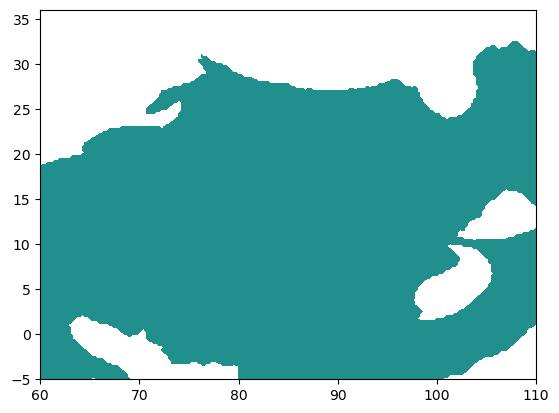

In [8]:
time_idx, labels, angles, crossfluxes, result_df = findARs(ivt.data, ivtrec.data,
            ivtano.data, qu.data, qv.data, latax, lonax, times=timeax, **PARAM_DICT)

## Show some results

After the computation is done, we could have a look at some of the results.

First print the number of ARs detected:

In [9]:
print("Number of ARs found during %s - %s = %d." %(TIME_START, TIME_END, len(result_df)))

Number of ARs found during 2022-06-01 18:00:00 - 2022-06-30 18:00:00 = 149.


Then print the first few records:

In [10]:
result_df.head(4)

,id,time,contour_y,contour_x,centroid_y,centroid_x,axis_y,axis_x,axis_rdp_y,axis_rdp_x,...,length,width,LW_ratio,strength,strength_ano,strength_std,max_strength,mean_angle,is_relaxed,qv_mean
0,1,2022-06-01 18:00:00,"[-0.775, -0.775, -0.775, -0.775, -0.775, -0.77...","[85.25, 85.5, 85.75, 86.0, 86.25, 86.5, 86.75,...",6.0,81.0,"[7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9...","[60.75, 61.0, 61.25, 61.5, 61.75, 62.0, 62.25,...","[7.75, 11.0, 5.75, 8.0]","[60.75, 64.0, 77.25, 101.25]",...,4738.058045,727.934744,6.508905,535.5328944179727,166.25226875009622,126.933526,873.446777,3.30127,False,32.999042
1,1,2022-06-02 00:00:00,"[-1.025, -1.025, -1.025, -1.025, -1.025, -1.02...","[85.5, 85.75, 86.0, 86.25, 86.5, 86.75, 87.0, ...",5.75,81.75,"[7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9...","[60.5, 60.75, 61.0, 61.25, 61.5, 61.75, 62.0, ...","[7.0, 11.0, 5.75, 8.5]","[60.5, 64.5, 80.5, 102.25]",...,4897.527808,723.268113,6.771386,527.6793888409939,158.93175288165244,129.437204,868.257141,3.165542,False,42.311484
2,1,2022-06-02 06:00:00,"[-0.775, -0.775, -0.775, -0.775, -0.775, -0.77...","[87.75, 88.0, 88.25, 88.5, 88.75, 89.0, 89.25,...",6.0,81.5,"[7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9...","[60.5, 60.75, 61.0, 61.25, 61.5, 61.75, 62.0, ...","[7.5, 11.25, 5.5, 7.0]","[60.5, 64.25, 81.0, 99.5]",...,4586.736747,744.365857,6.161939,507.22510901092824,143.0207421732903,130.566096,807.924011,7.496828,False,62.335373
3,1,2022-06-02 12:00:00,"[-0.525, -0.525, -0.525, -0.5, -0.275, -0.275,...","[90.5, 90.75, 91.0, 91.025, 91.25, 91.5, 91.52...",6.0,81.5,"[8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 1...","[60.0, 60.25, 60.5, 60.75, 61.0, 61.25, 61.5, ...","[8.0, 12.0, 5.75, 8.0]","[60.0, 64.0, 77.0, 98.5]",...,4598.060841,760.426189,6.046689,510.83282506076586,144.31865722512563,126.995452,817.217224,3.403812,False,38.225111


The columns of this table:

* **id**: integer numeric id for this AR at *this particular* time point. ARs at different time points can share the same **id**, and an AR can be uniquely identified with the combination of time stamp + id.
* **time**: time stamp in the YYYY-MM-DD HH:mm:ss format.
* **contour_y**: list of floats, the y-coordinates (latitudes) of the AR contour in degrees North.
* **contour_x**: list of floats, the x-coordinates (longitude) of the AR contour in degrees North.
* **centroid_y**: float, latitude of the AR centroid, weighted by the IVT value.
* **centroid_x**: float, longitude of the AR centroid, weighted by the IVT value.
* **axis_y**: list of floats, latitudes of the AR axis.
* **axis_x**: list of floats, longitude of the AR axis.
* **axis_rdp_y**: list of floats, latitude of the simplified AR axis.
* **axis_rdp_x**: list of floats, longitude of the simplified AR axis.
* **area**: float, area of the AR in $km^2$.
* **length**: float, length of the AR in $km$.
* **width**: float, effective width in $km$, as area/length.
* **LW_ratio**: float, length/width ratio.
* **strength**: float, spatially averaged IVT value within the AR region, in $kg/(m \cdot s)$.
* **strength_ano**: float, spatially averaged *anomalous* IVT value within the AR region, in $kg/ (m \cdot s)$.
* **strength_std**: float, standard deviation of IVT within the AR region, in $kg/(m \cdot s)$.
* **max_strength**: float, maximum IVT value within the AR region, in $kg/(m \cdot s)$.
* **mean_angle**: float, spatially averaged angle between the IVT vector and the AR axis, in degrees.
* **is_relaxed**: True or False, whether the AR is flagged as "relaxed".
* **qv_mean**: float, spatially averaged meridional integrated vapor flux, in $kg/(m \cdot s)$.




Now create some plots for the 1st time step with any detected ARs.

c:\Users\User\anaconda3\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


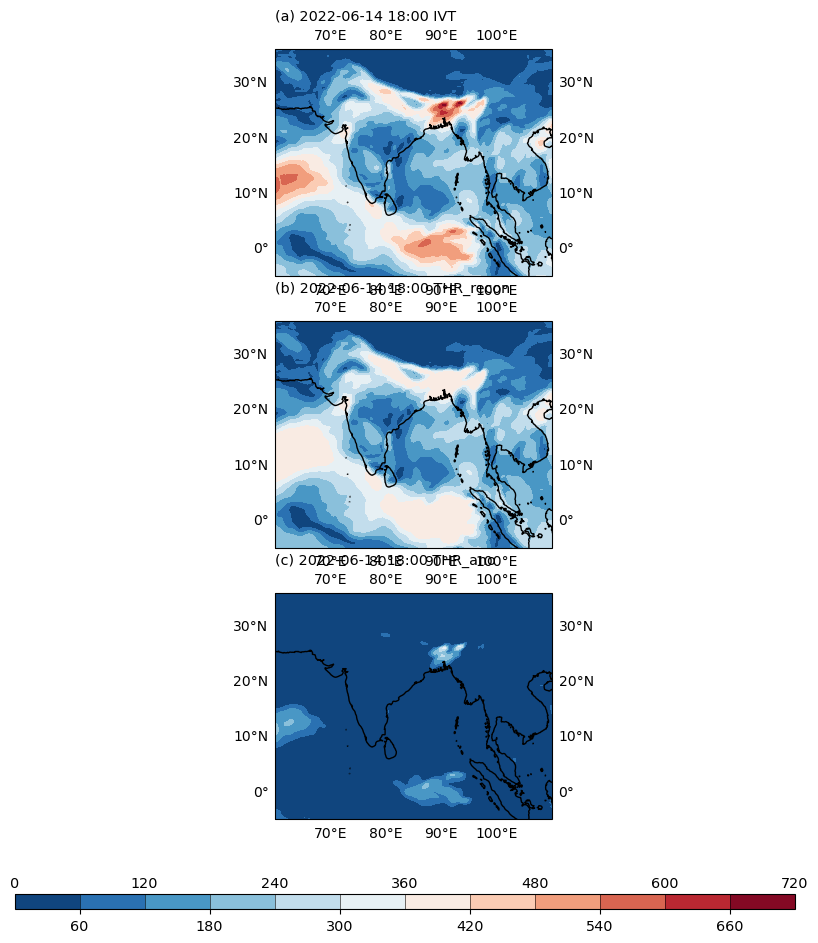

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from ipart.utils import plot

plot_idx=time_idx[52]

plot_time=timeax[plot_idx]
slab=ivt.data[plot_idx]
slabrec=ivtrec.data[plot_idx]
slabano=ivtano.data[plot_idx]
ardf=result_df[result_df.time==plot_time]

plot_vars=[slab, slabrec, slabano]
titles=['IVT', 'THR_recon', 'THR_ano']
iso=plot.Isofill(plot_vars, 12, 1, 1,min_level=0,max_level=800)

figure=plt.figure(figsize=(12,10), dpi=100)

for jj in range(len(plot_vars)):
    ax=figure.add_subplot(3,1,jj+1,projection=ccrs.PlateCarree())
    pobj=plot.plot2(plot_vars[jj], iso, ax,
            xarray=lonax, yarray=latax,                    
            title='%s %s' %(plot_time, titles[jj]),
            fix_aspect=False)
    plot.plotAR(ardf, ax, lonax)

Lastly, save the outputs to disk.

The `result_df` is saved to a `.csv` file.

The `np.set_printoptions()` function makes sure that in the saved `csv` table, the value in any cell does not contain any ellipsis `...`. This is because the coordinates of an AR axis is a list of float numbers. When this list goes too long, an ellipsis will be inserted in the saved `csv` output, e.g.

```
[12.232, 15.234, 17.3435, ..., 20.123, 24.333]
```

The same is also true for the AR contour coordinates.

To prevent this, the `np.set_printoptions()` function is called, with different input arguments for py2 and py3.

In [12]:
if not os.path.exists(OUTPUTDIR):
    os.makedirs(OUTPUTDIR)

abpath_out=os.path.join(OUTPUTDIR, 'ar_records.csv')
print('\n# Saving output to:\n',abpath_out)
# Necessary: to remove ... in csv file
if sys.version_info.major==2:
    np.set_printoptions(threshold=np.inf)
elif sys.version_info.major==3:
    np.set_printoptions(threshold=sys.maxsize)
result_df.to_csv(abpath_out,index=False)


# Saving output to:
 .\2022\ar_records.csv


Then save the labels to a `.nc` file.

In [13]:
abpath_out=os.path.join(OUTPUTDIR, 'ar_s_6_%d_labels.nc' %YEAR)
print('\n# Saving output to:\n',abpath_out)
funcs.saveNC(abpath_out, labels, 'w')
funcs.saveNC(abpath_out, angles, 'a')
funcs.saveNC(abpath_out, crossfluxes, 'a')


# Saving output to:
 .\2022\ar_s_6_2022_labels.nc
